In [1]:
# Install dependencies.
!rm -r sample_data
!pip install -qq --upgrade transformers compel accelerate git+https://github.com/TimothyAlexisVass/diffusers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.6 MB/s eta 0:00:00


In [2]:
# Set the details for your model here:
import torch

from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline, AutoencoderKL
use_refiner = False

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
_ = base.to("cuda")

if use_refiner:
  refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0",
      vae=vae,
      text_encoder_2=base.text_encoder_2,
      torch_dtype=torch.float16,
      variant="fp16",
      use_safetensors=True,
  )
  _ = refiner.to("cuda")

tokenizer = base.tokenizer            # cpu
tokenizer_2 = base.tokenizer_2        # cpu
scheduler = base.scheduler            # cpu
text_encoder = base.text_encoder      # cuda
text_encoder_2 = base.text_encoder_2  # cuda
unet = base.unet                      # cuda

torch.cuda.empty_cache()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
print(unet.parameters().__next__().device)
print(scheduler.sigmas)
torch.cuda.empty_cache()
!nvidia-smi
use_refiner = True

  0%|          | 0/20 [00:00<?, ?it/s]

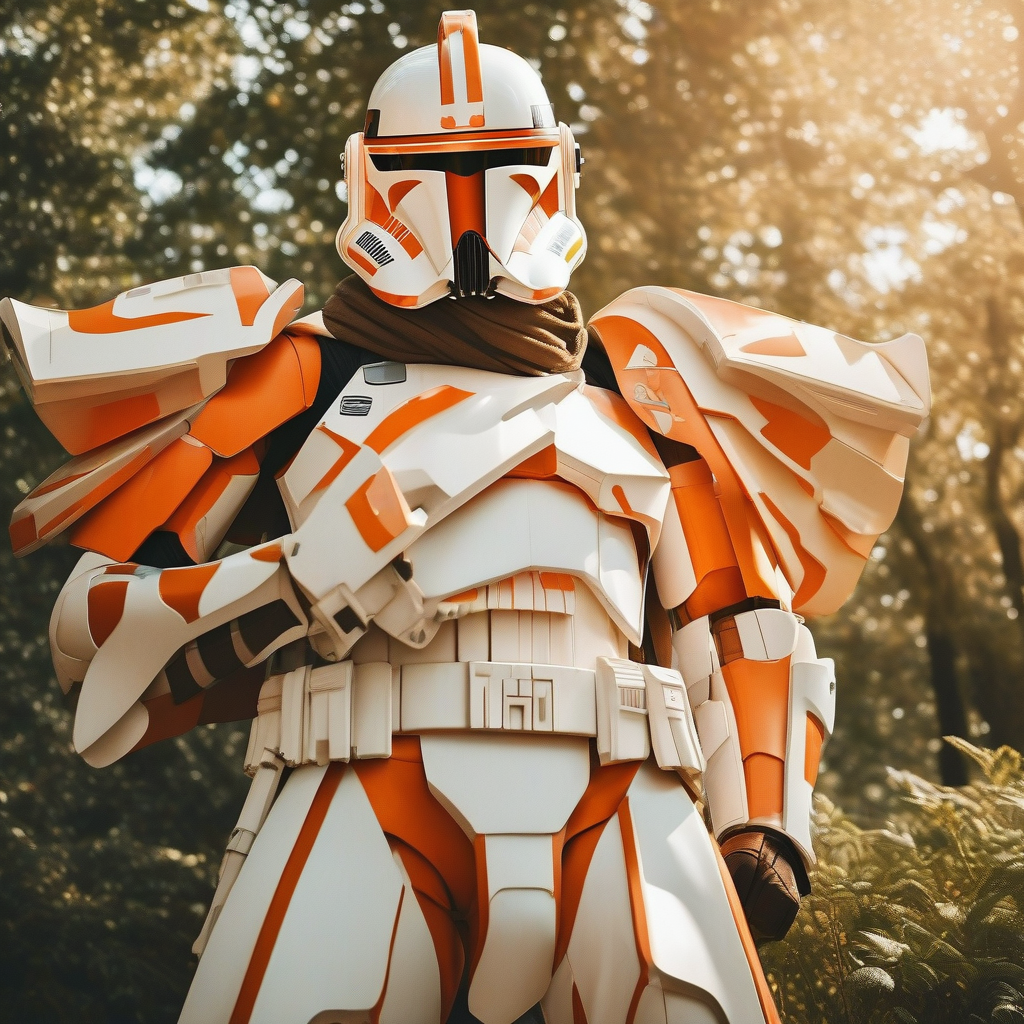

In [21]:
import os
import random
import torch
import diffusers
import numpy as np
from prompt_manager import process_prompt

# Define a function to apply Gaussian blur to a tensor
def latents_filter(latent_tensor, timestep, filter_type, kernel_size, sigma, filter_strength):
    num_channels = latent_tensor.shape[1]
    filtered_latents = []

    # Redefine filter_strength based on filter_strength and timestep
    timestep_factor = filter_strength * (1.0 - (timestep * 0.001))

    for i in range(num_channels):
        # Create a Gaussian kernel for blurring
        kernel = np.fromfunction(
            lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * np.exp(-((x - kernel_size//2)**2 + (y - kernel_size//2)**2) / (2 * sigma**2)),
            (kernel_size, kernel_size)
        )
        kernel = torch.FloatTensor(kernel).to("cuda")
        kernel = kernel / kernel.sum()

        kernel = kernel.view(1, 1, kernel_size, kernel_size).repeat(1, 1, 1, 1).to(latent_tensor.dtype)
        latent_channel = latent_tensor[:, i:i+1, :, :]

        filtered_channel = torch.nn.functional.conv2d(latent_channel, kernel, padding=kernel_size//2)

        if filter_type == 'sharpen':
            # Apply smoothing/sharpening by subtracting the filtered image from the original image
            filter_strength = 0.00025 * timestep_factor
            filtered_channel = latent_channel + filter_strength * (latent_channel - filtered_channel)
        elif filter_type == 'amplify':
            # Apply dampen/amplify by applying the filtered image to the original image
            filter_strength = 0.002 * timestep_factor
            if filter_strength > 0: filter_strength/=3
            filtered_channel = latent_channel + filter_strength * filtered_channel
        elif filter_type == 'enhance':
            # Apply edge enhancement with a Laplacian kernel
            filter_strength = 0.00003 * timestep_factor
            laplacian_kernel = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=latent_tensor.dtype).view(1, 1, 3, 3).to("cuda")
            edges = torch.nn.functional.conv2d(latent_channel, laplacian_kernel, padding=1)
            filtered_channel = latent_channel - filter_strength * edges

        filtered_latents.append(filtered_channel)

    return torch.cat(filtered_latents, dim=1)


prompt = "Photograph++++++++ In this visually stunning cinematic photo, a Jedi from the Star Wars universe stands proudly amidst a picturesque natural setting (perfect hands)+ in broad daylight. The Jedi is adorned in an intricately designed high-tech mecha armor, primarily white with striking orange accents that beautifully complement the lush surroundings. The white mecha armor showcases a level of sophistication and detailing that is truly awe-inspiring. Even the smallest particles on the armor are meticulously crafted, lending an air of authenticity and sophistication to the entire scene. This attention to detail extends to the environment as well, with every leaf, blade of grass, and intricate element of the landscape rendered with astonishing precision. The lighting in the image is nothing short of extraordinary. The natural daylight bathes the scene in a warm and inviting glow, highlighting the Jedi and the surrounding nature park in a way that is both visually captivating and emotionally evocative. The result is a sharp, well-lit portrait that captures the character's sense of happiness and serenity. The Jedi's outfit is nothing short of an aesthetic marvel. The combination of white mecha armor and vivid orange details is not just visually striking but also a testament to the designer's creative prowess. The careful interplay of colors, shades, and textures contributes to the overall appeal of the image. Beautiful shadows and contrasts add depth and dimension to the scene, enhancing the realism and vibrancy of the portrayal. The image is not just of high quality but possesses a level of photographic realism that transcends the boundaries of conventional artwork. The overall composition and attention to detail make this portrayal an absolute masterpiece. Rendered in ultra-high definition 8K resolution, this image is nothing short of a visual masterpiece, captivating the viewer with a level of intricacy and sophistication that is second to none. It is a testament to the artist's skill, dedication, and passion for creating a work of art that transports the viewer into a galaxy far, far away."

negative_prompt = "bokeh, robotic, helmet, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
num_inference_steps = 20

def callback(index, timestep, latents):
  if strength != 0:
    latents = latents_filter(latents, timestep, 'sharpen', kernel_size=13, sigma=3.0, filter_strength=strength)
    return {"latents": latents}

prompt = process_prompt(base, prompt_1 = prompt, negative_prompt_1 = negative_prompt)

parameters = {
    "prompt_embeds": prompt['positive']['embeds'],
    "pooled_prompt_embeds": prompt['positive']['pooled'],
    "negative_prompt_embeds": prompt['negative']['embeds'],
    "negative_pooled_prompt_embeds": prompt['negative']['pooled'],
    "num_inference_steps": num_inference_steps,
    "output_type": "latent",
    "num_images_per_prompt": 1,
    "guidance_scale": 8,
}

height = 1024
width = 1024
# latents = torch.randn((parameters["num_images_per_prompt"], base.unet.config.in_channels, height // 8, width // 8), generator=parameters["generator"]).to("cuda") * base.scheduler.init_noise_sigma

# latents = base.prepare_latents(parameters["num_images_per_prompt"], unet.config.in_channels, height, width, None, base.device, parameters["generator"])

def normalize_tensor(tensor):
  min_val = torch.min(tensor)
  return (tensor - min_val) / (torch.max(tensor) - min_val)

@torch.no_grad()
def decode_latents(latents, saturation=50, contrast=50, brightness=50, normalize=False):
    scaling = 4.444 + saturation / 16

    samples = vae.decode(latents * scaling).sample
    if normalize:
        samples = normalize_tensor(samples)
    else:
        samples = samples.mul(contrast/100).add(brightness/100).clamp(0, 1)
    return base.numpy_to_pil(samples.permute(0, 2, 3, 1).cpu().numpy())
for strength in range(0, 1, 2):
    if use_refiner:
      parameters["callback"]=callback
      wow = base(**parameters, generator=torch.manual_seed(2222), denoising_end=0.8).images
      parameters.pop("callback")
      parameters["num_inference_steps"]*=2
      wow = refiner(**parameters, generator=torch.manual_seed(2222), denoising_start=0.8, image=wow).images
      parameters["num_inference_steps"]//=2
    else:
      wow = base(**parameters, generator=torch.manual_seed(2222)).images

    image = decode_latents(wow, normalize=False)[0]
    if strength % 10 == 0:
      display(image)
    image.save(f"{strength}.png")



In [ ]:
!zip -r png_files.zip *.png
!rm -r *.png